# Choosing a location for a well

Let's say you work for the mining company GlavRosGosNeft. We need to decide where to drill a new well.

You have been provided with oil samples in three regions: in each of 10,000 fields, where the quality of oil and the volume of its reserves have been measured. Build a machine learning model to help determine the region where mining will bring the most profit. Analyze possible profits and risks using the *Bootstrap* technique

Steps to choose a location:

- In the selected region, they are looking for deposits, for each, the values of the signs are determined;
- Build a model and estimate the volume of reserves;
- Select the deposits with the highest value estimates. The number of fields depends on the company's budget and the cost of developing one well;
- The profit is equal to the total profit of the selected deposits.

**Conditions of the problem:**
Only linear regression is suitable for training the model (the rest are not predictable enough).
During the exploration of the region, 500 points are explored, from which, using machine learning, the best 200 are selected for development.
The budget for the development of wells in the region is 10 billion rubles.
At current prices, one barrel of raw materials brings 450 rubles of income. The income from each unit of the product is 450 thousand rubles, since the volume is indicated in thousands of barrels.
After assessing the risks, you need to leave only those regions in which the probability of losses is less than 2.5%. Among them, choose the region with the highest average profit.

Content
1. [Loading and preparing data](#start)
2. [Training and checking models](#model_training)
3. [Preparation for profit calculation](#prep)
4. [Calculation of profit and risks](#profit)

## Loading and preparing data <a id='start'></a> 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import shuffle

In [2]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

dfs = [geo_data_0, geo_data_1, geo_data_2]

geo_data_0.name = 'geo_data_0'   
geo_data_1.name = 'geo_data_1'
geo_data_2.name = 'geo_data_2'

for df in dfs:
    display(df.name, df.head())

'geo_data_0'

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


'geo_data_1'

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


'geo_data_2'

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [3]:
for df in dfs:
    display(df.info())

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 100000 entries, 0 to 99999

Data columns (total 5 columns):

 #   Column   Non-Null Count   Dtype  

---  ------   --------------   -----  

 0   id       100000 non-null  object 

 1   f0       100000 non-null  float64

 2   f1       100000 non-null  float64

 3   f2       100000 non-null  float64

 4   product  100000 non-null  float64

dtypes: float64(4), object(1)

memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 100000 entries, 0 to 99999

Data columns (total 5 columns):

 #   Column   Non-Null Count   Dtype  

---  ------   --------------   -----  

 0   id       100000 non-null  object 

 1   f0       100000 non-null  float64

 2   f1       100000 non-null  float64

 3   f2       100000 non-null  float64

 4   product  100000 non-null  float64

dtypes: float64(4), object(1)

memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 100000 entries, 0 to 99999

Data columns (total 5 columns):

 #   Column   Non-Null Count   Dtype  

---  ------   --------------   -----  

 0   id       100000 non-null  object 

 1   f0       100000 non-null  float64

 2   f1       100000 non-null  float64

 3   f2       100000 non-null  float64

 4   product  100000 non-null  float64

dtypes: float64(4), object(1)

memory usage: 3.8+ MB


None

Primary analysis of exploration data of three regions showed:
1. The table provides information:
* id - unique identifier of the well;
* f0, f1, f2 - three signs of points (it doesn't matter what they mean, but the signs themselves are significant);
* product - the volume of reserves in the well (thousand barrels).

2. There are no gaps.
3. In all dataframes id - object, f0, f1, f2, product - float64.
4. Quantitative data (f0, f1, f2, product) have a different scale (scatter of values).

Check dataframes for duplicates. We will assume that the lines are duplicated if they have repeated values ​​in the id column.

In [4]:
for df in dfs:
    display('Number of duplicates in a dataframe {}: {}'
            .format(df.name, df[df.duplicated('id', keep=False)]
            .shape[0]))

'Количество дублей в датафрейме geo_data_0: 20'

'Количество дублей в датафрейме geo_data_1: 8'

'Количество дублей в датафрейме geo_data_2: 8'

The number of duplicates is small and amounts to 2% in geo_data_0, 0.8% in geo_data_1, 0.8% in geo_data_2, so we will remove them from dataframes.

In [5]:
for df in dfs:
    name = df.name
    df = df.drop_duplicates(subset='id', keep=False).reset_index(drop=True)
    df.name = name
    display('Number of duplicates in dataframe {} after deletion: {}'
            .format(df.name, df[df.duplicated('id', keep=False)]
            .shape[0]))

'Количествово дублей в датафрейме geo_data_0 после удаления: 0'

'Количествово дублей в датафрейме geo_data_1 после удаления: 0'

'Количествово дублей в датафрейме geo_data_2 после удаления: 0'

Let's remove the identifier column (id), which will not be used in the model.

In [6]:
for df in dfs:
    df.drop('id', axis=1, inplace=True)
    display(df.name, df.head())

'geo_data_0'

,f0,f1,f2,product
0,0.705745,-0.497823,1.221170,105.280062
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265647
3,-0.032172,0.139033,2.978566,168.620776
4,1.988431,0.155413,4.751769,154.036647


'geo_data_1'

,f0,f1,f2,product
0,-15.001348,-8.276000,-0.005876,3.179103
1,14.272088,-3.475083,0.999183,26.953261
2,6.263187,-5.948386,5.001160,134.766305
3,-13.081196,-11.506057,4.999415,137.945408
4,12.702195,-8.147433,5.004363,134.766305


'geo_data_2'

,f0,f1,f2,product
0,-1.146987,0.963328,-0.828965,27.758673
1,0.262778,0.269839,-2.530187,56.069697
2,0.194587,0.289035,-5.586433,62.871910
3,2.236060,-0.553760,0.930038,114.572842
4,-0.515993,1.716266,5.899011,149.600746


Let's divide the sample into training (75%) and validation (25%).

In [7]:
#create dictionaries for training and validation samples for all dataframes,
#where the key is the name of the dataframe,
#and the value is a set of features of the corresponding dataframe
df_train = {}
df_valid = {}

for df in dfs:
    df_train[df.name], df_valid[df.name] = train_test_split(
        df, test_size=0.25, random_state=12345)
    train_size = len(df_train[df.name]) / len(df)
    valid_size = len(df_valid[df.name]) / len(df)
    display('Percentage of the training sample of the dataframe {}: {:.0%}'.format(df.name, train_size))
    display('Percentage of the validation sample of the dataframe  {}: {:.0%}'.format(df.name, valid_size))

'Доля обучающей выборки датафрейма geo_data_0: 75%'

'Доля валидационной выборки датафрейма geo_data_0: 25%'

'Доля обучающей выборки датафрейма geo_data_1: 75%'

'Доля валидационной выборки датафрейма geo_data_1: 25%'

'Доля обучающей выборки датафрейма geo_data_2: 75%'

'Доля валидационной выборки датафрейма geo_data_2: 25%'

Let's create variables for the features and the target feature.

In [8]:
features_train = {}
features_valid = {}
target_train = {}
target_valid = {}
for df in dfs:
    features_train[df.name] = df_train[df.name].drop('product', axis=1)
    features_valid[df.name] = df_valid[df.name].drop('product', axis=1)
    target_train[df.name] = df_train[df.name]['product']
    target_valid[df.name] = df_valid[df.name]['product']

Since there is a spread of values ​​in the signs, it is necessary to standardize the samples.

In [9]:
numeric = ['f0','f1','f2']
for df in dfs:
    scaler = StandardScaler()
    scaler.fit(features_train[df.name])
    features_train[df.name][numeric] = scaler.transform(features_train[df.name][numeric])
    features_valid[df.name][numeric] = scaler.transform(features_valid[df.name][numeric])

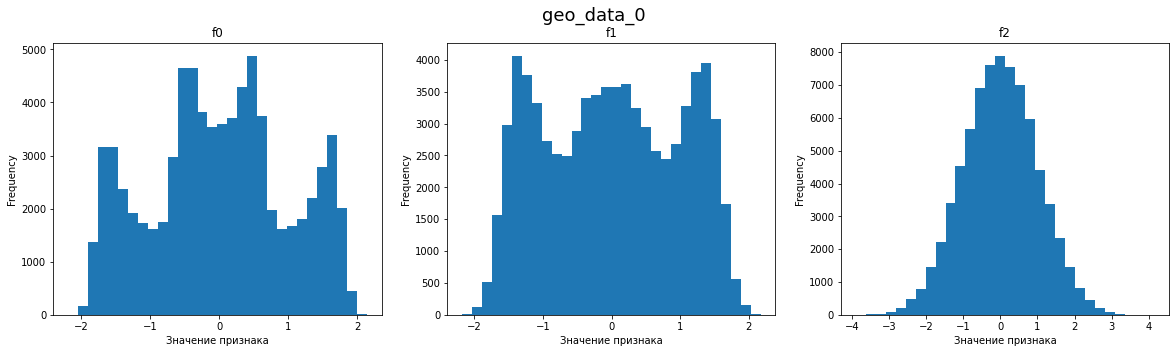

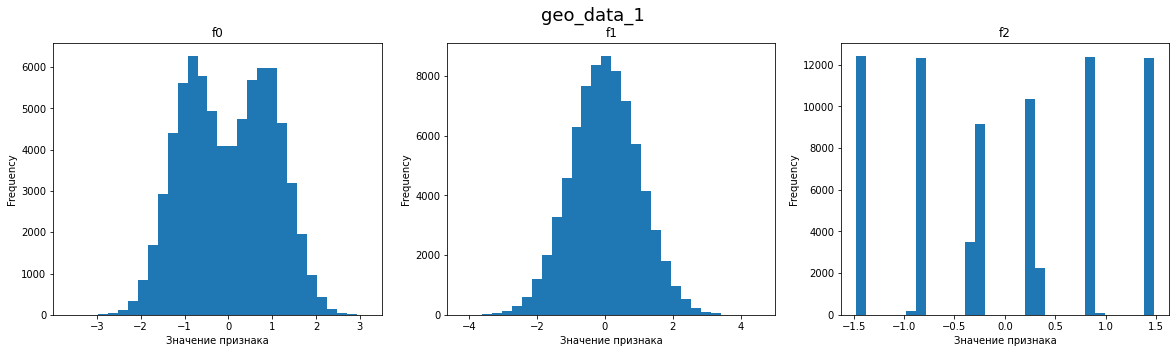

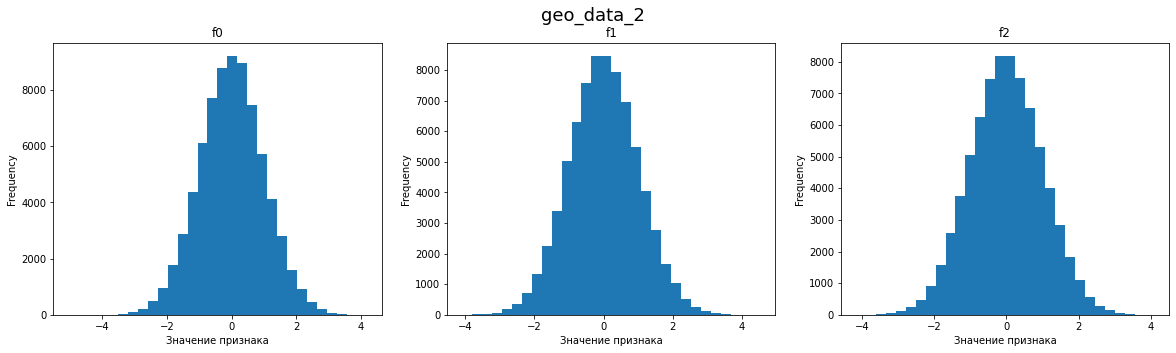

In [10]:
for df in dfs:
    fig = plt.figure(figsize=(20, 5))
    ttl = fig.suptitle(df.name, fontsize=18)
    rows = 1
    cols = 3
    counter = 1
    for column in ['f0', 'f1', 'f2']:
        ax = plt.subplot(rows, cols, counter)
        plt.xlabel('Feature value')
        plt.ylabel('Quantity, pcs.')
        ax.set_title(column)
        features_train[df.name][column].plot(kind='hist', bins=30)
        counter += 1
plt.show()

All attributes of dataframes are distributed around the value 0.

## Training and checking models <a id='model_training'></a> 

Let's train the models using linear regression.

In [11]:
#create dictionaries to store the target feature/features (dictionary value)
#by corresponding dataframe (dictionary key)
predicted_valid = {}
predicted_valid_top200 = {}
target_valid_top200 = {}
features_valid_top200 = {}
model = {}

#models
for df in dfs:
    model[df.name] = LinearRegression()
    model[df.name].fit(features_train[df.name], target_train[df.name])
    predicted_valid[df.name] = pd.Series(data=model[df.name]
                                                            .predict(features_valid[df.name]),
                                                            index=features_valid[df.name]
                                                            .index)
    
#the top 200 wells in each region
    predicted_valid_top200[df.name] = (predicted_valid[df.name]
                                                              .sort_values(ascending=False)
                                                              .head(200)
                                      )
    selected_indexes = predicted_valid_top200[df.name].index
    target_valid_top200[df.name] = target_valid[df.name].loc[selected_indexes]
    
    predicted_valid_top200_mean = predicted_valid_top200[df.name].mean()
    rmse_top200 = mean_squared_error(target_valid_top200[df.name], predicted_valid_top200[df.name]) ** 0.5
    
    rmse= mean_squared_error(target_valid[df.name], predicted_valid[df.name]) ** 0.5
    r2 = r2_score(target_valid[df.name], predicted_valid[df.name])
    
    display('Region {}'.format(df.name))
    display('Average stock of predicted raw materials for the top 200 wells:           {:0.0f} тыс.'.
          format(predicted_valid_top200_mean))
    display('RMSE for top 200 wells:                                                   {:0.0f} тыс.'.
          format(rmse_top200))
    display('RMSE across the entire validation set:                                    {:0.0f} тыс.'.
          format(rmse))
    display('Determination coefficient R2 (over the entire validation set):            {:.2%}'.
          format(r2))
    print('')

'Регион geo_data_0'

'Средний запас предсказанного сырья для топ-200 скважин:           156 тыс.'

'RMSE для топ-200 скважин:                                         27 тыс.'

'RMSE по всей валидационной выборке:                               38 тыс.'

'Коэффициент детерминации R2 (по всей валидационной выборке):      27.99%'

'Регион geo_data_1'

'Средний запас предсказанного сырья для топ-200 скважин:           139 тыс.'

'RMSE для топ-200 скважин:                                         1 тыс.'

'RMSE по всей валидационной выборке:                               1 тыс.'

'Коэффициент детерминации R2 (по всей валидационной выборке):      99.96%'

'Регион geo_data_2'

'Средний запас предсказанного сырья для топ-200 скважин:           148 тыс.'

'RMSE для топ-200 скважин:                                         29 тыс.'

'RMSE по всей валидационной выборке:                               40 тыс.'

'Коэффициент детерминации R2 (по всей валидационной выборке):      20.52%'

Models trained on the data of geo_data_0 and geo_data_2 regions have a weak predictive ability, as evidenced by the low value of the coefficient of determination (R2). The model trained on the data of geo_data_1 region has the largest coefficient of determination R2, therefore it has the best quality, despite the fact that it predicted the smallest amount of the average product.

## Preparation for profit calculation <a id='prep'></a> 

Let's save all key values for calculations in separate variables.

In [12]:
N = 500 #number of points explored during exploration of the region, pcs.
M = 200 #the number of the best points selected using machine learning for development, pcs.
TOTAL_COSTS = 10000000000 #well development budget in one region, rubles
REVENUE_PER_OIL_WELL = 450000 #income from each unit of product, rubles
LOSS_PROBABILITY  = 0.025 #loss probability

Let us calculate a sufficient volume of raw materials for the break-even development of a new well. Since the volume is indicated in thousands of barrels, the calculation will be carried out per thousand units.

In [13]:
loss_per_oil_well = TOTAL_COSTS / M #consumption per well
necessary_product = loss_per_oil_well / REVENUE_PER_OIL_WELL
display('Required volume of raw materials per well for break-even development of a new well: {:0.0f} thousand barrels'
        .format(necessary_product))

'Необходимый объем сырья на одну скважину для безубыточной разработки новой скважины: 111 тыс. баррелей'

The average reserves of predicted raw materials in the regions (geo_data_0 - 156 thousand barrels, geo_data_1 - 139 thousand barrels, geo_data_3 - 148 thousand barrels) are more than the required volume of raw materials for break-even development of a new well. The highest value of the average volume of raw materials in the geo_data_0 region.

Let's write a function to calculate the profit for the selected wells and model predictions. Calculate the profit for the received volume of raw materials.

In [14]:
def total_profit(data, region):
    features = data.drop('product', axis=1)
    targets = data['product']
    predictions = model[region].predict(features)
    predictions = pd.Series(predictions, index=features.index)
    selected_oil_well = (predictions
                                    .sort_values(ascending=False)
                                    .head(200)
                                    .index
                        )
    revenue = (targets
                     .loc[selected_oil_well]
                     .sum() * REVENUE_PER_OIL_WELL
              )
    costs = TOTAL_COSTS
    profit = revenue - costs
    return profit

for df in dfs:
    display('Profit by region {} : {:0.2f} billion rubles'.format(df.name, total_profit(df_train[df.name], df.name) / 1000000000 ))

'Прибыль по региону geo_data_0 : 3.02 млрд. руб.'

'Прибыль по региону geo_data_1 : 2.42 млрд. руб.'

'Прибыль по региону geo_data_2 : 2.55 млрд. руб.'

## Calculation of profit and risks <a id='profit'></a>  

Let's calculate the risks and profits for each region. Let's find the profit distribution using the Bootstrap technique.

In [15]:
state = np.random.RandomState(12345)
bootstrap_samples = 1000

values_profit = {}
for df in dfs:
    values_profit[df.name] = []
    for i in range(bootstrap_samples):
        subsample = df.sample(n=N, replace=False, random_state=state)
        values_profit[df.name].append(total_profit(data=subsample, region=df.name))
    values_profit[df.name] = pd.Series(values_profit[df.name])


Let's look at the distribution of profits for each region.

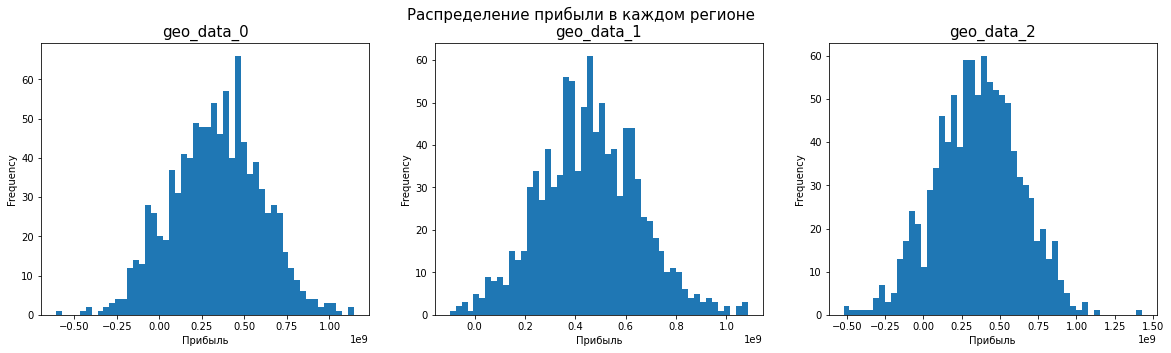

In [16]:
fig = plt.figure(figsize=(20, 5))
ttl = fig.suptitle('Distribution of profits in each region', fontsize=15)

rows = 1
cols = 3
counter = 1
for df in dfs:
    ax = plt.subplot(rows, cols, counter)
    plt.xlabel('Profit', fontsize=10)
    plt.ylabel('Quantity, pcs.', fontsize=10)
    ax.set_title(df.name, fontsize=15)
    values_profit[df.name].plot(kind='hist', bins=50)
    counter += 1
plt.show()

Let's calculate the average profit for each region. Profit will be rounded up to millions. Let's find the 95% confidence interval, which contains the general average profit from the development of the region.

In [17]:
for df in dfs:
    profit_mean = values_profit[df.name].mean() / 1000000 
    display('Average profit in the region {}: {:0.0f} million rubles'.format(df.name, profit_mean))
    lower = values_profit[df.name].quantile(0.025) / 1000000
    upper = values_profit[df.name].quantile(0.975) / 1000000
    display('Confidence interval for average profit in the region {}: [{:0.0f}, {:0.0f}] (million rubles)'.
          format(df.name, lower, upper))
    loss_prob = (values_profit[df.name] < 0).mean()
    display('Probability of getting a loss in the region {}: {:.0%}'.format(df.name, loss_prob))
    print('')

'Средняя прибыль в регионе geo_data_0: 335 млн. руб.'

'Доверительный интервал для средней прибыли в регионе geo_data_0: [-163, 829] (млн. руб.)'

'Вероятность получить убыток в регионе geo_data_0: 12%'

'Средняя прибыль в регионе geo_data_1: 457 млн. руб.'

'Доверительный интервал для средней прибыли в регионе geo_data_1: [67, 858] (млн. руб.)'

'Вероятность получить убыток в регионе geo_data_1: 1%'

'Средняя прибыль в регионе geo_data_2: 356 млн. руб.'

'Доверительный интервал для средней прибыли в регионе geo_data_2: [-167, 872] (млн. руб.)'

'Вероятность получить убыток в регионе geo_data_2: 11%'

The geo_data_1 region satisfies the loss probability threshold condition (less than 2.5%). To develop the field, the geo_data_1 region is proposed as a region with a low probability of losses (1%) and the highest average profit from development (457 million rubles).